In [382]:
import torch
from einops import rearrange, repeat
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm.auto import trange, tqdm

def load_kernel_files(directory="kernels_out_mi_no_pool"):
    """
    Load all .pt files from the specified directory.
    
    Args:
        directory (str): Directory containing kernel files
        
    Returns:
        dict: Dictionary mapping filenames to loaded kernel data
    """
    kernel_files = glob.glob(os.path.join(directory, "*.pt"))
    kernels = []
    names = []
    for file_path in tqdm(kernel_files):
        try:
            kernel_data = torch.load(file_path)
            Z = kernel_data['Z'].cuda()
            #K = Z @ Z.T
            K = kernel_data['K'].cuda() # this is the cosine kernel
            # Define kernel functions
            kernel_functions = {
                "linear": lambda Z: Z @ Z.T,
                "squared_norm": lambda Z: torch.exp(-0.1 * torch.cdist(Z, Z, p=2)**2),
                "cosine": lambda Z: Z @ Z.T / (torch.norm(Z, dim=1, keepdim=True) @ torch.norm(Z, dim=1, keepdim=True).T),
                "polynomial": lambda Z: (Z @ Z.T + 1)**2,
                "rbf": lambda Z: torch.exp(-0.1 * torch.cdist(Z, Z, p=2)**2),
                "rbf_cosine": lambda Z: torch.exp(-0.1 * torch.cdist(Z, Z, p=2)**2) * (Z @ Z.T / (torch.norm(Z, dim=1, keepdim=True) @ torch.norm(Z, dim=1, keepdim=True).T))            }
            #K = kernel_functions['rbf_cosine'](Z)
            # Default kernel function (can be changed as a parameter)
            #kernel_function_name = "linear"  # Change this to use different kernels
            #normed_Z = Z / torch.norm(Z, dim=1, keepdim=True)
            #kernel = kernel_functions['linear'](Z)
            #kernel = kernel_data['K'] / torch.linalg.norm(kernel_data['K'])
            #kernel = kernel_functions['cosine'](Z)
            # apply standard kernel normalization
            # Apply normalization where K(i,j) = K(i,j) / sqrt(K(i,i) * K(j,j))
            # This is equivalent to normalizing by the square root of the diagonal elements
            
            #diag_values = torch.diagonal(kernel)
            #norm_factors = torch.sqrt(torch.outer(diag_values, diag_values))
            # Center the kernel using H = I - 1/n 11^T
            # This is equivalent to K_centered = HKH where H is the centering matrix
            n = K.shape[0]
            ones = torch.ones(n, 1, device=K.device)
            H = torch.eye(n, device=K.device) - (1/n) * (ones @ ones.T)
            kernel = H @ K @ H
            
            #Fro norm
            kernel = kernel / torch.linalg.norm(kernel)
            
            #trace norm
            #kernel = kernel / torch.trace(kernel)

            #diag norm K(i,j) = K(i,j) / sqrt(K(i,i) * K(j,j))
            #kernel = kernel / torch.sqrt(torch.outer(torch.diagonal(kernel), torch.diagonal(kernel)))

            kernels.append(kernel.cpu())
            file_name = Path(file_path).stem
            names.append(file_name)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(kernels)} kernel files from {directory}")
    return kernels, names

# Load all kernel files
kernels, names = load_kernel_files()

  0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipykernel_130717/725352815.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kernel_data = torch.load(file_path)


Loaded 33 kernel files from kernels_out_mi_no_pool


In [383]:
def compute_expectation_variance(K: torch.Tensor,
                                 M: torch.Tensor,
                                 T: float = 1.0) -> Tuple[torch.Tensor,
                                                          torch.Tensor]:
    """Return Σ M σ and Σ M² σ(1‑σ) with σ = sigmoid(K/T)."""
    sigma       = torch.sigmoid(K / T)
    expectation = (M * sigma).sum()
    variance    = ((M**2) * sigma * (1 - sigma)).sum()
    return expectation, variance

In [384]:
import seaborn as sns

T = 0.01
expectations = np.zeros((len(kernels), len(kernels)))
variances = np.zeros((len(kernels), len(kernels)))
for i in trange(len(kernels)):
    for j in range(len(kernels)):
        K = kernels[i].cuda()
        M = kernels[j].cuda()
        expectation, variance = compute_expectation_variance(K, M, T)
        expectations[i, j] = expectation.cpu()
        variances[i, j] = variance.cpu()

  0%|          | 0/33 [00:00<?, ?it/s]

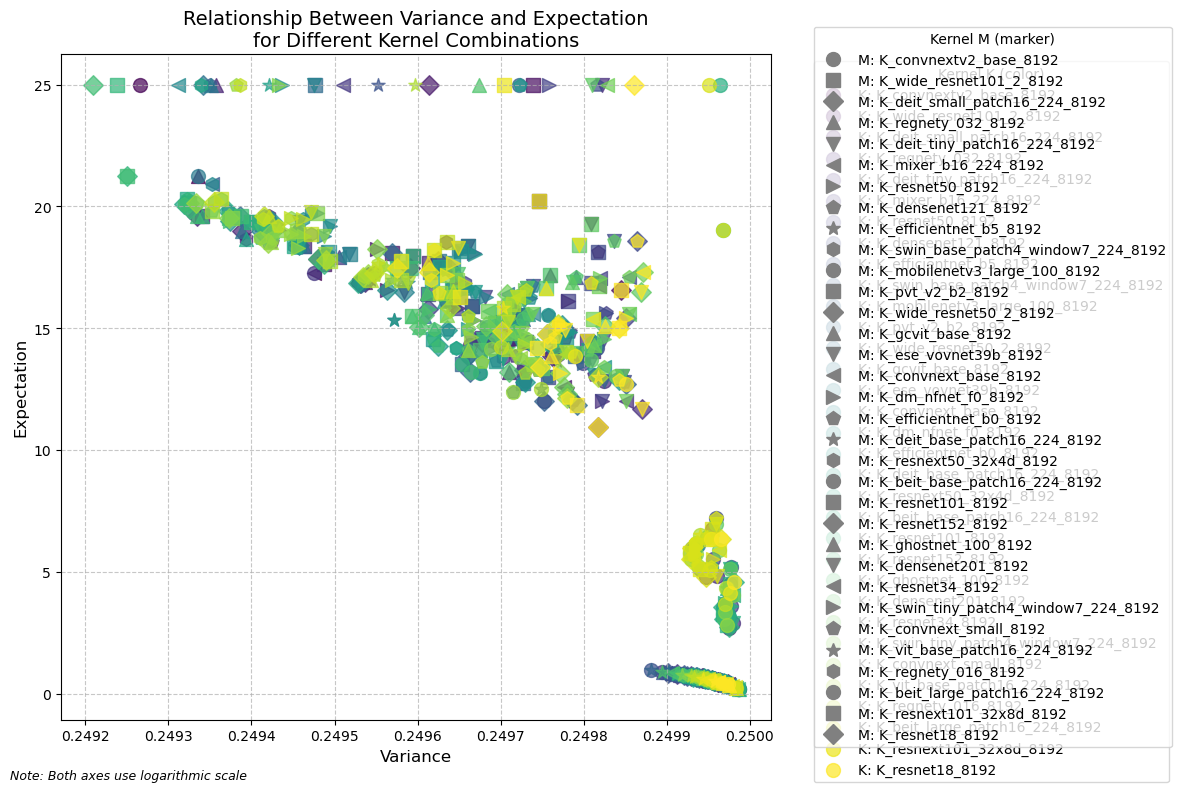

In [385]:
# Create a clearer visualization of expectation vs variance relationships
plt.figure(figsize=(12, 8))

# Use a distinct marker style for each M kernel and color for each K kernel
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

# Create a dictionary to track which combinations we've already plotted for the legend
plotted_K = set()
plotted_M = set()

# Plot all points
for K_idx in range(len(kernels)):
    for M_idx in range(len(kernels)):
        # Get the point for this K,M combination
        y_val = expectations[K_idx, M_idx]  # Now y-axis is expectation
        x_val = variances[K_idx, M_idx]     # Now x-axis is variance
        
        # Determine if this should be in the legend (first occurrence of this K or M)
        k_label = f"K: {names[K_idx]}" if names[K_idx] not in plotted_K else None
        if k_label:
            plotted_K.add(names[K_idx])
        
        # Plot this point
        plt.scatter(x_val, y_val, 
                    s=100,                          # Larger point size
                    color=colors[K_idx],            # Color by K kernel
                    marker=markers[M_idx % len(markers)],  # Shape by M kernel
                    alpha=0.7,                      # Slight transparency
                    label=k_label)                  # Label only for legend


# Add a separate legend for M markers
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='gray', 
                         label=f"M: {names[i]}", markersize=10, linestyle='None')
                  for i in range(len(names))]

# First legend for K colors
first_legend = plt.legend(title="Kernel K (color)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(first_legend)

# Second legend for M markers
plt.legend(handles=legend_elements, title="Kernel M (marker)", 
           bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.ylabel('Expectation', fontsize=12)  # Now y-axis is expectation
plt.xlabel('Variance', fontsize=12)     # Now x-axis is variance
plt.title('Relationship Between Variance and Expectation\nfor Different Kernel Combinations', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
# Set both x and y axes to logarithmic scale
#plt.xscale('log')
#plt.yscale('log')

# Add a note about the log scale
plt.figtext(0.01, 0.01, "Note: Both axes use logarithmic scale", 
            fontsize=9, style='italic', ha='left')

plt.tight_layout()
plt.show()


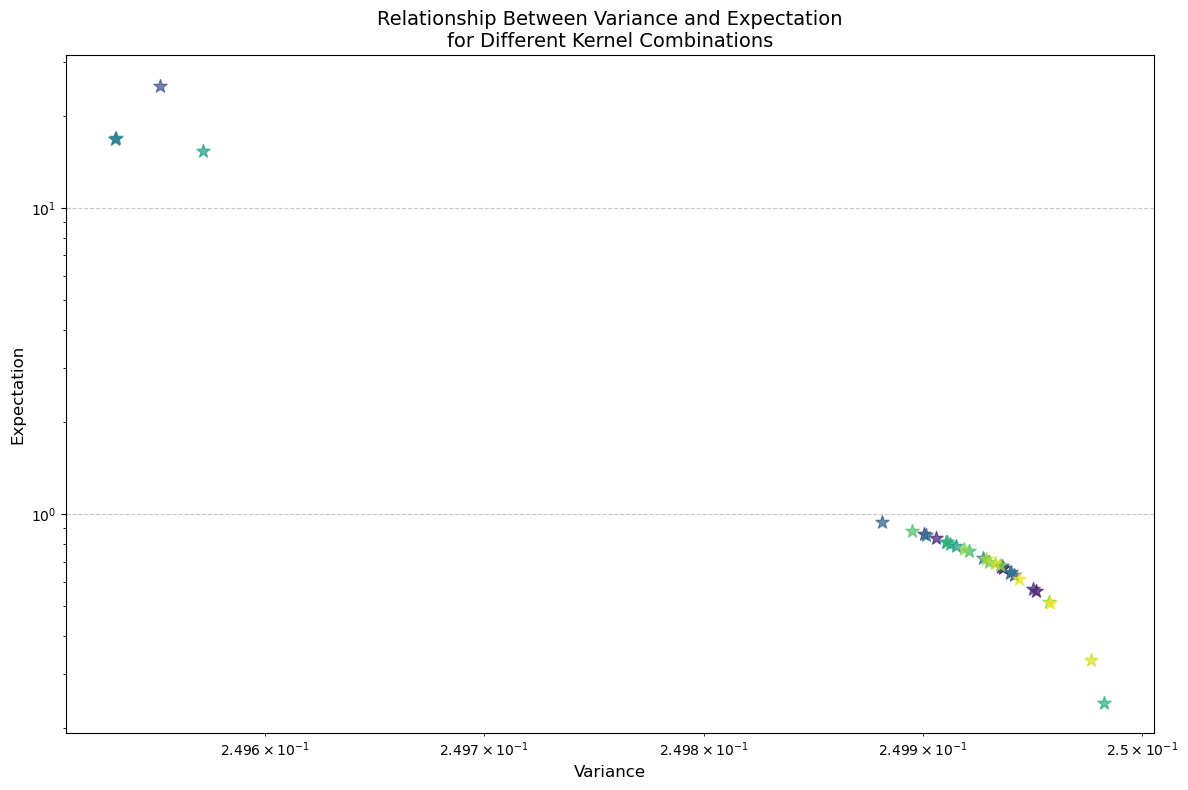

In [386]:
# Create a clearer visualization of expectation vs variance relationships
plt.figure(figsize=(12, 8))

# Use a distinct color for each M kernel and marker for each K kernel
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

# Create a dictionary to track which combinations we've already plotted for the legend
plotted_K = set()
plotted_M = set()

# Plot all points
K_idx = 8
for M_idx in range(len(kernels)):
    # Get the point for this K,M combination
    y_val = expectations[K_idx, M_idx]  # Now y-axis is expectation
    x_val = variances[K_idx, M_idx]     # Now x-axis is variance
    
    # Determine if this should be in the legend (first occurrence of this M)
    m_label = f"M: {names[M_idx]}" if names[M_idx] not in plotted_M else None
    if m_label:
        plotted_M.add(names[M_idx])
    
    # Plot this point
    plt.scatter(x_val, y_val, 
                s=100,                          # Larger point size
                color=colors[M_idx],            # Color by M kernel
                marker=markers[K_idx % len(markers)],  # Shape by K kernel
                alpha=0.7,                      # Slight transparency
                label=m_label)                  # Label only for legend


# Add a separate legend for K markers
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[K_idx % len(markers)], color='gray', 
                         label=f"K: {names[K_idx]}", markersize=10, linestyle='None')]

# First legend for M colors
first_legend = plt.legend(title="Kernel M (color)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().add_artist(first_legend)

# Second legend for K markers
#plt.legend(handles=legend_elements, title="Kernel K (marker)", 
#           bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.ylabel('Expectation', fontsize=12)  # Now y-axis is expectation
plt.xlabel('Variance', fontsize=12)     # Now x-axis is variance

plt.xscale('log')
plt.yscale('log')
plt.title('Relationship Between Variance and Expectation\nfor Different Kernel Combinations', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [387]:
names2 = ['K_deit_tiny_patch16_224_8192', 'K_deit_small_patch16_224_8192',
       'K_pvt_v2_b2_8192', 'K_resnet34_8192', 'K_resnet18_8192',
       'K_beit_base_patch16_224_8192', 'K_convnext_small_8192',
       'K_vit_base_patch16_224_8192',
       'K_swin_tiny_patch4_window7_224_8192', 'K_mixer_b16_224_8192',
       'K_regnety_016_8192', 'K_gcvit_base_8192',
       'K_convnextv2_base_8192', 'K_beit_large_patch16_224_8192',
       'K_ese_vovnet39b_8192', 'K_densenet121_8192',
       'K_ghostnet_100_8192', 'K_efficientnet_b0_8192',
       'K_mobilenetv3_large_100_8192', 'K_regnety_032_8192',
       'K_densenet201_8192', 'K_resnet152_8192', 'K_resnext50_32x4d_8192',
       'K_resnet101_8192', 'K_wide_resnet50_2_8192', 'K_resnet50_8192',
       'K_wide_resnet101_2_8192', 'K_resnext101_32x8d_8192',
       'K_dm_nfnet_f0_8192', 'K_deit_base_patch16_224_8192',
       'K_convnext_base_8192', 'K_swin_base_patch4_window7_224_8192',
       'K_efficientnet_b5_8192']

lin_acc = [55.43924332, 58.02527618, 59.31306076, 59.72530365, 59.77190018,
       61.0616951 , 61.43900681, 61.83656311, 61.8662796 , 62.16342163,
       62.71563339, 63.67829895, 63.77212906, 63.85028839, 64.10680389,
       64.46328735, 65.5326767 , 66.26106262, 66.39875793, 67.74736786,
       70.72195435, 71.07073975, 71.0758667 , 71.24276733, 71.32904053,
       71.37088013, 71.43492889, 71.49388123, 77.90781403, 82.66225433,
       84.03491211, 85.15244293, 86.57562256]
lin_var = [225.93507806, 127.37279293, 103.02852848,  82.72487797,
        79.89186632, 101.45232765,  73.55732815,  61.93639821,
        64.28293083,  57.16151812,  57.74531554,  55.41580796,
        51.76430813,  47.52105376,  41.07507344,  35.47825843,
        30.39168891,  26.98277716,  28.45961432,  26.04047471,
        14.47339675,  16.82304884,  16.61298327,  16.85213084,
        15.79075691,  14.54687022,  14.17648595,  12.88689402,
         7.00417503,   8.8294982 ,   6.58378618,   5.91661007,
         3.77199792]

In [388]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import numpy as np
from scipy.stats import pearsonr

def check_pearsons(K_index, verbose=False, remove_outliers=False, z_threshold=2):
    df = pd.DataFrame()
    df['names'] = names
    df['tr_var'] = variances[K_index,:]
    df['tr_exp'] = expectations[K_index,:]
    #df['tr_var'] = np.log(variances[K_index,:])
    #df['tr_exp'] = np.log(expectations[K_index,:])

    df2 = pd.DataFrame()
    df2['names'] = names2
    df2['lnacc'] = lin_acc
    df2['lnvar'] = lin_var
    
    # Find the intersection of names in df and df2
    common_names = list(set(df['names']).intersection(set(df2['names'])))

    # Create a new dataframe with data from both df and df2 for common names
    df_both = pd.DataFrame()
    df_both['names'] = common_names

    # Add columns from df
    for name in common_names:
        df_idx = df[df['names'] == name].index[0]
        df_both.loc[df_both['names'] == name, 'tr_exp'] = df.loc[df_idx, 'tr_exp']
        df_both.loc[df_both['names'] == name, 'tr_var'] = df.loc[df_idx, 'tr_var']

    # Add columns from df2
    for name in common_names:
        df2_idx = df2[df2['names'] == name].index[0]
        df_both.loc[df_both['names'] == name, 'lnacc'] = df2.loc[df2_idx, 'lnacc']
        df_both.loc[df_both['names'] == name, 'lnvar'] = df2.loc[df2_idx, 'lnvar']

    # Remove outliers if requested
    if remove_outliers:
        original_count = len(df_both)
        
        # Function to remove outliers based on z-score
        def remove_outliers_zscore(df, column, threshold):
            z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
            return df[z_scores < threshold]
        
        # Remove outliers from each column
        df_both = remove_outliers_zscore(df_both, 'tr_exp', z_threshold)
        df_both = remove_outliers_zscore(df_both, 'tr_var', z_threshold)
        df_both = remove_outliers_zscore(df_both, 'lnacc', z_threshold)
        df_both = remove_outliers_zscore(df_both, 'lnvar', z_threshold)
        
        removed_count = original_count - len(df_both)
        if verbose and removed_count > 0:
            print(f"Removed {removed_count} outliers out of {original_count} data points")

    # Calculate R^2 scores
    r2_acc_exp = r2_score(df_both['lnacc'], df_both['tr_exp'])
    r2_var = r2_score(df_both['lnvar'], df_both['tr_var'])

    # Calculate Pearson correlation coefficients
    pearson_acc_exp, p_value_acc = pearsonr(df_both['lnacc'], df_both['tr_exp'])
    pearson_var, p_value_var = pearsonr(df_both['lnvar'], df_both['tr_var'])

    if verbose:
        print(f"R^2 between linear accuracy and trace of exponential: {r2_acc_exp:.4f}")
        print(f"Pearson correlation (accuracy vs trace exp): {pearson_acc_exp:.4f}, p-value: {p_value_acc:.4e}")
        print(f"R^2 between linear variance and trace variance: {r2_var:.4f}")
        print(f"Pearson correlation (variance vs trace variance): {pearson_var:.4f}, p-value: {p_value_var:.4e}")

        # Create scatter plots with lines of best fit
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 5))

        # Plot for accuracy vs trace exp
        plt.subplot(1, 2, 1)
        plt.scatter(df_both['tr_exp'], df_both['lnacc'])

        # Add line of best fit
        m, b = np.polyfit(df_both['tr_exp'], df_both['lnacc'], 1)
        x_range = np.linspace(min(df_both['tr_exp']), max(df_both['tr_exp']), 100)
        plt.plot(x_range, m*x_range + b, 'r-')

        plt.xlabel('Trace of Exponential')
        plt.ylabel('Linear Accuracy')
        plt.title(f'Linear Accuracy vs Trace Exp\nR²={r2_acc_exp:.4f}, Pearson r={pearson_acc_exp:.4f}')

        # Plot for variance vs trace variance
        plt.subplot(1, 2, 2)
        plt.scatter(df_both['tr_var'], df_both['lnvar'])

        # Add line of best fit
        m, b = np.polyfit(df_both['tr_var'], df_both['lnvar'], 1)
        x_range = np.linspace(min(df_both['tr_var']), max(df_both['tr_var']), 100)
        plt.plot(x_range, m*x_range + b, 'r-')

        plt.xlabel('Trace Variance')
        plt.ylabel('Linear Variance')
        plt.title(f'Linear Variance vs Trace Variance\nR²={r2_var:.4f}, Pearson r={pearson_var:.4f}')

        plt.tight_layout()
        plt.show()

    return pearson_acc_exp, pearson_var

In [393]:
best_k = -1
best_sum = 0
sums = []
for k in trange(len(kernels)):
    p_mean, p_var = check_pearsons(k, remove_outliers=False)
    sums.append(p_mean + p_var)
    if p_mean + p_var > best_sum:
        best_k = k
        best_sum = p_mean + p_var

  0%|          | 0/33 [00:00<?, ?it/s]

In [390]:
best_sum, best_k

(1.181643839112103, 8)

R^2 between linear accuracy and trace of exponential: -66.1418
Pearson correlation (accuracy vs trace exp): 0.7867, p-value: 5.6945e-08
R^2 between linear variance and trace variance: -1.0601
Pearson correlation (variance vs trace variance): 0.3949, p-value: 2.2925e-02


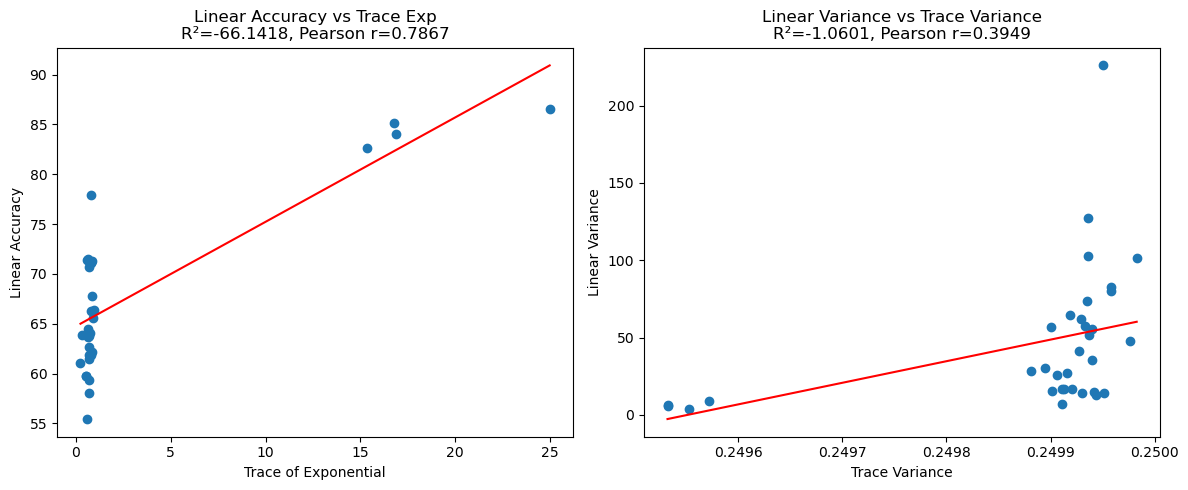

(0.7866955464693535, 0.39494829264274944)

In [391]:
check_pearsons(best_k, verbose = True, remove_outliers=False)

In [392]:
names[best_k]

'K_efficientnet_b5_8192'

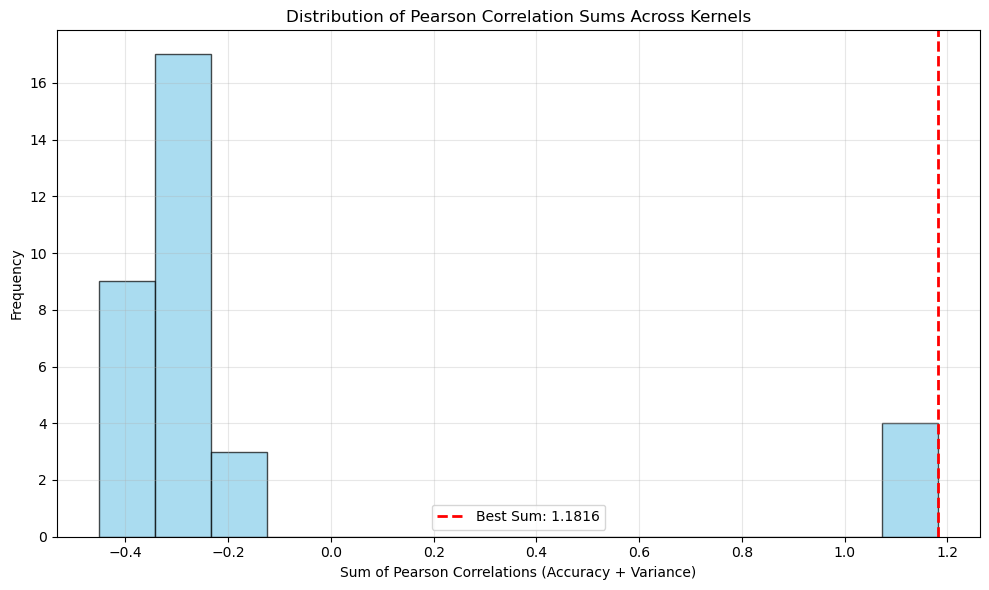

In [394]:
# Plot histogram of the sum of Pearson correlations
plt.figure(figsize=(10, 6))
plt.hist(sums, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(best_sum, color='red', linestyle='dashed', linewidth=2, label=f'Best Sum: {best_sum:.4f}')
plt.xlabel('Sum of Pearson Correlations (Accuracy + Variance)')
plt.ylabel('Frequency')
plt.title('Distribution of Pearson Correlation Sums Across Kernels')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
